# Graph Coloring with Physics-Inspired Graph Neural Networks(SAGE)

In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
import os.path

2.5.0+cu121
0.20.0+cu121


In [ ]:
import random
import torch
import warnings
import numpy as np
import networkx as nx
import os
import torch.nn as nn
import torch.nn.functional as F


from time import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
try:
    import torch_geometric
except ImportError:
    !pip install torch_geometric
    import torch_geometric

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GCNConv
from itertools import chain

In [ ]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [ ]:
SEED_VALUE = 0           #lo richiamo anche sotto per get_gnn
random.seed(SEED_VALUE)        # seed python RNG
np.random.seed(SEED_VALUE)     # seed global NumPy RNG
torch.manual_seed(SEED_VALUE)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [ ]:
cd /content/drive/MyDrive/FEDECOLOR

/content/drive/MyDrive/FEDECOLOR


In [ ]:
ls

data/                                                  requirements.txt
errore_per100semi_8x8.txt                              SAGE_best_model_coloring_11X11.pth
gc_example.ipynb                                       SAGE_best_model_coloring_13X13.pth
gc_example_prova1.ipynb                                SAGE_best_model_coloring_5X5.pth
GCN_best_model_coloring_5X5.pth                        SAGE_best_model_coloring_6X6.pth
instances.tar                                          SAGE_best_model_coloring_7X7
minimal_utils.py                                       SAGE_best_model_coloring_7X7.pth
minimal_utils_vecchiaprova2.ipynb                      SAGE_best_model_coloring_8X12.pth
minimal_utils_vecchiaprova3.py                         SAGE_best_model_coloring_9X9.pth
minimal_utils_vecchiaprova4.py                         SAGE_best_model_coloring_anna.pth
minimal_utils_vecchiaprova5_primaAttivazioneAparte.py  SAGE_best_model_coloring_myciel5
minimal_utils_vecchiaprova.py                 

In [ ]:
# Known chromatic numbers for specified problems (from references)
chromatic_numbers = {
    # COLOR graphs
    'jean.col': 10,
    'anna.col': 11,
    'huck.col': 11,
    'david.col': 11,
    'homer.col': 13,
    'myciel5.col': 6,
    'myciel6.col': 7,
    'queen5_5.col': 5,
    'queen6_6.col': 7,
    'queen7_7.col': 7,
    'queen8_8.col': 9,
    'queen9_9.col': 10,
    'queen8_12.col': 12,
    'queen11_11.col': 11,
    'queen13_13.col': 13,
    # Citations graphs
    'cora.cites': 5,
    'citeseer.cites': 6,
    'pubmed.cites': 8
}

In [ ]:
#FACCIO FUNZIONE CHE SALVA BEST MODELLO COSI NON DEVO CAMBIARE SOTTO IL NOME DEL FILE
def save_model(model,path, best_cost, best_loss, epoch):
    torch.save(model.state_dict(), path)                    #aggiunto stasera
    print(f'Model saved with best_cost: {best_cost:.1f}  and best_loss(soft loss): {best_loss:.4f} at the epoch: {epoch}')

In [ ]:
#funzione per cambiare il seme nel train
def set_seed(seed):
    """
    Sets random seeds for training.

    :param seed: Integer used for seed.
    :type seed: int
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [ ]:
def get_adjacency_matrix(nx_graph, torch_device, torch_dtype):
    """
    Pre-load adjacency matrix, map to torch device

    :param nx_graph: Graph object to pull adjacency matrix for
    :type nx_graph: networkx.OrderedGraph   per me cambiato con DiGraph/Graph
    :param torch_device: Compute device to map computations onto (CPU vs GPU)
    :type torch_dtype: str
    :param torch_dtype: Specification of pytorch datatype to use for matrix
    :type torch_dtype: str
    :return: Adjacency matrix for provided graph
    :rtype: torch.tensor
    """

    adj = nx.linalg.graphmatrix.adjacency_matrix(nx_graph).todense()
    adj_ = torch.tensor(adj).type(torch_dtype).to(torch_device)

    return adj_

In [ ]:
def parse_line(file_line, node_offset):
    """
    Helper function to parse lines out of COLOR files - skips first character, which
    will be an "e" to denote an edge definition, and returns node0, node1 that define
    the edge in the line.

    :param file_line: Line to be parsed
    :type file_line: str
    :param node_offset: How much to add to account for file numbering (i.e. offset by 1)
    :type node_offset: int
    :return: Set of nodes connected by edge defined in the line (i.e. node_from, node_to)
    :rtype: int, int
    """

    x, y = file_line.split(' ')[1:]  # skip first character - specifies each line is an edge definition
    x, y = int(x)+node_offset, int(y)+node_offset  # nodes in file are 1-indexed, whereas python is 0-indexed (NON PENSO SIA QUESTO IL PROBLEMA)
    return x, y

In [ ]:
def build_graph_from_color_file(fname, node_offset=-1, parent_fpath=''):               #sta tutto qua come creo grafico
    """
    Load problem definition (graph) from COLOR file (e.g. *.col).

    :param fname: Filename of COLOR file
    :type fname: str
    :param node_offset: How much to offset node values contained in file
    :type node_offset: int
    :param parent_fpath: Path to prepend to `fname`
    :type parent_fpath: str
    :return: Graph defined in provided file
    :rtype: networkx.OrderedGraph === CAMBIATO con network.DiGraph
    """

    fpath = os.path.join(parent_fpath, fname)

    print(f'Building graph from contents of file: {fpath}')
    with open(fpath, 'r') as f:
        content = f.read().strip()

    # Identify where problem definition starts.
    # All lines prior to this are assumed to be miscellaneous descriptions of file contents
    # which start with "c = p".
    start_idx = [idx for idx, line in enumerate(content.split('\n')) if line.startswith('p')][0]
    lines = content.split('\n')[start_idx:]  # skip comment line(s)
    edges = [parse_line(line, node_offset) for line in lines[1:] if len(line) > 0]

    nx_temp = nx.from_edgelist(edges)

    nx_graph = nx.Graph()    #QUESTO É TUTTO, se metto DiGraph é grafo DIRETTO, sennó Undirect concettualmente é piu giusto
    nx_graph.add_nodes_from(sorted(nx_temp.nodes()))    #qua mi sa leva i link doppi, ma quando creo torch tensor non lo fa
    nx_graph.add_edges_from(nx_temp.edges)

    return nx_graph

In [ ]:
#definisco funzione che mi calcola errore come:
#numero di edges sbagliate con potts/num link
def err_gen(cost_discreto,num_link_torch):
  num_vero_link=num_link_torch*0.5
  eps=cost_discreto/num_vero_link               #dovrebbe considerare che il grafo é indiretto sia nel costo discreto che nel numero dei link

  return eps

# Step 1 - Set hyperparameters - Devo cambiare solo qua(NB solvey_hypers in realtá li ridefinisco sotto nel train ma tanto so sempre uguali)

We provide a default set of model hypers. Feel free to modify these as desired.

We also include general parameters such as tolerance and patience for early stopping, the layer aggregation specification (`layer_agg_type`) for GraphSAGE, and some tracking of problem definition (problem name, chromatic number).

In [ ]:
# Specify the problem instance to solve and where to find the dataset(s) here:

problem_file = 'queen8_8.col'     #tipo prima era 'queen5_5.col'    #RICORDA DI CAMBIARE IL FILE IN CUI METTI IL BEST MODELLO

#save_model_path = 'SAGE_best_model_coloring_8X8.pth'   #se cambio problem file, devo cambare anche il nome del file dove salvo il modello addestrato
save_errore_path = 'SAGE_errore_8X8_100semi.pth'

input_parent = './data/input/COLOR/instances'

In [ ]:
# Sample hyperparameters
hypers = {
        'model': 'SAGEConv',   # set either with GNN. It cannot take other input (lo metto dopo)      #sono quelli di GCN conv
        'dim_embedding': 32,
        'dropout': 0.2878,
        'learning_rate':    0.02728,
        'hidden_dim': 10,
        'seed': SEED_VALUE
        #'num_seeds':100
    }


# Default meta parameters
solver_hypers = {
    'tolerance': 1e-3 , #pri           # Loss must change by more than tolerance, or add towards patience count
    'number_epochs': int(1e4),   # Max number training steps   #non lo cambio da qui
    'patience': 500,             # Number early stopping triggers before breaking loop #non lo cambio da qui
    'graph_file': problem_file,  # Which problem is being solved
    'layer_agg_type': 'mean',    # How aggregate neighbors sampled within graphSAGE
    'number_classes': chromatic_numbers[problem_file]
}

# Combine into a single set
hypers.update(solver_hypers)

# Step 2 - Load in problem and create graph

Load in problem definition from specified path. Variables `input_parent` and `problem_file` should be defined appropriately in cell 3.

In [ ]:
from torch_geometric.utils import from_networkx

In [ ]:
# Establish full input location
input_fpath = os.path.join(input_parent, problem_file)

# Load in graph
nx_graph = build_graph_from_color_file(input_fpath, node_offset=-1, parent_fpath='')

# Get DGL graph from networkx graph
# Ensure relevant objects are placed onto proper torch device
torchgeom_graph = from_networkx(nx_graph)
torchgeom_graph = torchgeom_graph.to(TORCH_DEVICE)

Building graph from contents of file: ./data/input/COLOR/instances/queen8_8.col


In [ ]:
print('torchgeom_graf=',torchgeom_graph)    #oh ok
print(torchgeom_graph.num_nodes)
print(torchgeom_graph.edge_index)

torchgeom_graf= Data(edge_index=[2, 1456], num_nodes=64)
64
tensor([[ 0,  0,  0,  ..., 63, 63, 63],
        [ 9, 18, 27,  ..., 60, 61, 62]])


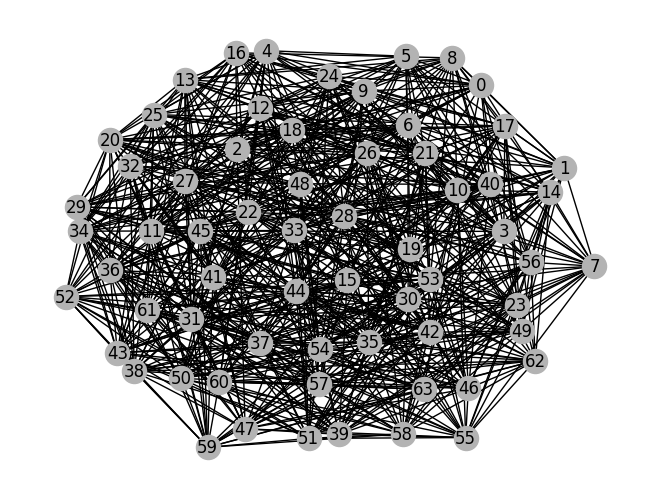

In [ ]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [ ]:
#creo classe della mia GNN


class GraphSAGE(nn.Module):
    """
    Basic GraphConv-based GNN class object. Constructs the model architecture upon
    initialization. Defines a forward step to include relevant parameters - in this
    case, just dropout.
    """
                            #self é la sua roba, g é torchgeom_graph
    def __init__(self, g, in_feats, hidden_size, num_classes, dropout):   #le in_feats diventano dim_embedding, hidden size e num_classes é da hypers
        """
        Initialize the model object. Establishes model architecture and relevant hypers (`dropout`, `num_classes`, `agg_type`)

        :param g: Input graph object
        :type g: Data of torch geometric
        :param in_feats: Size (number of nodes) of input layer
        :type in_feats: int
        :param hidden_size: Size of hidden layer
        :type hidden_size: int
        :param num_classes: Size of output layer (one node per class)
        :type num_classes: int
        :param dropout: Dropout fraction, between two convolutional layers
        :type dropout: float
        """

        super(GraphSAGE, self).__init__()
        self.g = g
        self.conv1 = SAGEConv(in_feats, hidden_size)
        self.relu=nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.conv2 = SAGEConv(hidden_size, num_classes)

    def forward(self, g):
        """
        Define forward step of netowrk. In this example, pass inputs through convolution, apply relu
        and dropout, then pass through second convolution.

        :param features: Input node representations
        :type features: torch.tensor
        :return: Final layer representation, pre-activation (i.e. class logits)
        :rtype: torch.tensor"""

        x, edge_index = g.x, g.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
print(torchgeom_graph)

Data(edge_index=[2, 1456], num_nodes=64)


In [ ]:
dim_embedding = hypers['dim_embedding']
hidden_dim = hypers['hidden_dim']
dropout = hypers['dropout']
number_classes = hypers['number_classes']
agg_type = hypers['layer_agg_type'] or 'mean'
model=hypers['model']
print(model)

SAGEConv


In [ ]:
print(hidden_dim)

10


In [ ]:
#messo nel ciclo sui semi

#embed = nn.Embedding(torchgeom_graph.num_nodes, dim_embedding)    #sto creando matrice  #sarebbero le in_feat ==  dim_embedding, creo #copie di valori dei nodi pari a dim_embedding
#embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
#print(embed)

In [ ]:
#messo nel ciclo sui semi

#data = Data(x=embed.weight, edge_index=torchgeom_graph.edge_index)
#print(data.x.shape)
#print(data.edge_index.shape)   #OK

In [ ]:
#ANCHE QUESTO DOPO INSIEME A CICLO SEMI
'''# instantiate the GNN
print(f'Building {model} model...')
if model=='SAGEConv':
  net = GraphSAGE(data, dim_embedding, hidden_dim, number_classes, dropout)      #sarebbe la mia classe che devo definire (fatto sopra)
  #def cosi net = GraphSAGE(in_channels=dim_embedding, hidden_channels=dim_embedding, out_channels=num_classes)
elif model == 'GNN':
  #net = GCN(Conv)
  print('ci va l altra')

print(net)'''

"# instantiate the GNN\nprint(f'Building {model} model...')\nif model=='SAGEConv':\n  net = GraphSAGE(data, dim_embedding, hidden_dim, number_classes, dropout)      #sarebbe la mia classe che devo definire (fatto sopra)\n  #def cosi net = GraphSAGE(in_channels=dim_embedding, hidden_channels=dim_embedding, out_channels=num_classes)\nelif model == 'GNN':\n  #net = GCN(Conv)\n  print('ci va l altra')\n\nprint(net)"

In [ ]:
# Retrieve known optimizer hypers
opt_hypers = {
    'lr': hypers.get('learning_rate', None)
}

# Get adjacency matrix for use in calculations
adj_ = get_adjacency_matrix(nx_graph, TORCH_DEVICE, TORCH_DTYPE)   #NON CAMBIA CON I SEMI PERCHE DIPENDE DAL GRAFO

# See minimal_utils.py for description. Constructs GNN and optimizer objects from given hypers.
# Initializes embedding layer to use as initial model input   #QUESTO DEVO FARLO DOPO
#net, embed, optimizer gia def

In [ ]:
print(adj_.shape)
print(adj_)

torch.Size([64, 64])
tensor([[0., 1., 1.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [1., 0., 0.,  ..., 1., 1., 0.]])


In [ ]:
'''# set up Adam optimizer
params = chain(net.parameters(), embed.parameters())

print('Building ADAM-W optimizer...')
optimizer = torch.optim.AdamW(params, **opt_hypers, weight_decay=1e-2)            #weight_decay = decadimento esponenziale che contiene overfitting
#scheduler= torch.optim.lr_scheduler.StepLR(optimizer,step_size=100000,gamma=1.5)    #AGGIUNTA IL 18/10 #step_size, ogni quante epoche il lr diminuisce del 10%(gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500)


print(optimizer)'''

"# set up Adam optimizer\nparams = chain(net.parameters(), embed.parameters())\n\nprint('Building ADAM-W optimizer...')\noptimizer = torch.optim.AdamW(params, **opt_hypers, weight_decay=1e-2)            #weight_decay = decadimento esponenziale che contiene overfitting\n#scheduler= torch.optim.lr_scheduler.StepLR(optimizer,step_size=100000,gamma=1.5)    #AGGIUNTA IL 18/10 #step_size, ogni quante epoche il lr diminuisce del 10%(gamma=0.1)\n#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500)\n\n\nprint(optimizer)"

In [ ]:
# helper function for graph-coloring loss
def loss_func_mod(probs, adj_tensor):
    """
    Function to compute cost value based on soft assignments (probabilities)

    :param probs: Probability vector, of each node belonging to each class
    :type probs: torch.tensor
    :param adj_tensor: Adjacency matrix, containing internode weights
    :type adj_tensor: torch.tensor
    :return: Loss, given the current soft assignments (probabilities)
    :rtype: float
    """

    # Multiply probability vectors, then filter via elementwise application of adjacency matrix.
    #  Divide by 2 to adjust for symmetry about the diagonal
    loss_ = torch.mul(adj_tensor, (probs @ probs.T)).sum() / 2

    return loss_      #sarebbe la mia energia di potts

# helper function for custom loss according to Q matrix
def loss_func_color_hard(coloring, nx_graph):
    """
    Function to compute cost value based on color vector (0, 2, 1, 4, 1, ...)

    :param coloring: Vector of class assignments (colors)
    :type coloring: torch.tensor
    :param nx_graph: Graph to evaluate classifications on
    :type nx_graph: networkx.OrderedGraph  --> da me cambiato con DiGraph
    :return: Cost of provided class assignments
    :rtype: torch.tensor
    """

    cost_ = 0
    for (u, v) in nx_graph.edges:
        cost_ += 1*(coloring[u] == coloring[v])*(u != v)     #1 if the two nodes have the same color and are not the same node

    return cost_


In [ ]:
print(nx_graph.edges)

[(0, 9), (0, 18), (0, 27), (0, 36), (0, 45), (0, 54), (0, 63), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 16), (0, 24), (0, 32), (0, 40), (0, 48), (0, 56), (1, 9), (1, 10), (1, 19), (1, 28), (1, 37), (1, 46), (1, 55), (1, 8), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 17), (1, 25), (1, 33), (1, 41), (1, 49), (1, 57), (2, 9), (2, 18), (2, 11), (2, 20), (2, 29), (2, 38), (2, 47), (2, 16), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 10), (2, 26), (2, 34), (2, 42), (2, 50), (2, 58), (3, 27), (3, 12), (3, 21), (3, 30), (3, 39), (3, 10), (3, 17), (3, 24), (3, 4), (3, 5), (3, 6), (3, 7), (3, 11), (3, 19), (3, 35), (3, 43), (3, 51), (3, 59), (4, 18), (4, 36), (4, 13), (4, 22), (4, 31), (4, 11), (4, 25), (4, 32), (4, 5), (4, 6), (4, 7), (4, 12), (4, 20), (4, 28), (4, 44), (4, 52), (4, 60), (5, 45), (5, 14), (5, 23), (5, 12), (5, 19), (5, 26), (5, 33), (5, 40), (5, 6), (5, 7), (5, 13), (5, 21), (5, 29), (5, 37), (5, 53), (5, 61), (6, 27), (6, 54), (6, 15), (6, 1

In [ ]:
print(nx_graph.number_of_edges())

728


In [ ]:
# Ensure RNG seeds are reset each training run
num_seeds=100    #creo semi da 0 a 9


number_epochs=hypers['number_epochs']    #forse dovrei mettere meno
patience=hypers['patience']
tolerance=hypers['tolerance']

errore_SEEDS=[]

for i in range(0,num_seeds):
  seed=i
  print(f'Start training(): Setting seed to {seed}')
  set_seed(seed)

  #ridefinisco qui l'embedding e data
  embed = nn.Embedding(torchgeom_graph.num_nodes, dim_embedding)    #sto creando matrice  #sarebbero le in_feat ==  dim_embedding, creo #copie di valori dei nodi pari a dim_embedding
  embed = embed.type(TORCH_DTYPE).to(TORCH_DEVICE)
  #creato embedding
            #print('Creato embedding =', embed)
  data = Data(x=embed.weight, edge_index=torchgeom_graph.edge_index)

  # instantiate the GNN
            #print(f'\t Building {model} model...')   #inrealta lo faccio con net
  net = GraphSAGE(data, dim_embedding, hidden_dim, number_classes, dropout)

  # set up Adam optimizer
  params = chain(net.parameters(), embed.parameters())
            #print('\t Building ADAM-W optimizer...')
  optimizer = torch.optim.AdamW(params, **opt_hypers, weight_decay=1e-2)

  # Tracking
  best_cost = torch.tensor(float('Inf'))  # high initialization
  best_loss = torch.tensor(float('Inf'))
  best_coloring = None

  # Early stopping to allow NN to train to near-completion
  prev_loss = 1.  # initial loss value (arbitrary)
  cnt = 0  # track number times early stopping is triggered
  #count_stessicolori=0


  #metto conto del tempo
  t_start = time()
  loss_vector_story=[]
  hard_cost_vector_story=[]


  # Training logic
  for epoch in range(number_epochs):
      # get soft prob assignments
      logits = net(data)       #rispetto a prima net mi prende tutto il formato data

      # apply softmax for normalization
      probs = F.softmax(logits, dim=1)       #qua dovrebbe normalizzare
      #print('probs=',probs)
      #print(probs.shape)           #========esce 25x5 (sarebbero le 5 prob dei 5 colori per ogni nodo, poi devo prendere quella maggiore)

      # get cost value with POTTS cost function
      loss = loss_func_mod(probs, adj_)              #calcolo la loss con modello potts

      # get cost based on current hard class assignments
      # update cost if applicable
      coloring = torch.argmax(probs, dim=1)
      #print(coloring.shape)                             #questo é effettivamente il vettore dei colori di questa epoca (con 25 elementi che sono numeri da 0 a 4)
      cost_hard = loss_func_color_hard(coloring, nx_graph)           #nodi diversi ma collegati e dello stesso colore

      if cost_hard < best_cost:           #best_cost= il miglior cost_hard    #best_coloring=il coloring col miglior cost_hard
          best_loss = loss
          best_cost = cost_hard     #sarebbe sbaglio 'discreto'
          best_coloring = coloring
          #save_model(net,save_model_path, best_cost, best_loss, epoch)


      # Early stopping check
      # If loss increases or change in loss is too small, trigger
      if (abs(loss - prev_loss) <= tolerance) | ((loss - prev_loss) > 0):
          cnt += 1
      else:
          cnt = 0


      # update loss tracking
      prev_loss = loss

      loss_vector_story.append(loss.item())
      hard_cost_vector_story.append(cost_hard.item())

      if cnt >= patience:
          print(f'Stopping early on epoch {epoch}. Patience count: {cnt}')
          break

      # run optimization with backpropagation
      optimizer.zero_grad()  # clear gradient for step
      loss.backward()  # calculate gradient through compute graph
      optimizer.step()  # take step, update weights
      #scheduler.step()

  # Print final loss
  print('\t Epoch %d | Final loss: %.5f' % (epoch, loss.item()))
  print('\t Epoch %d | Lowest discrete cost: %.2f  ' % (epoch, best_cost))

  # Final coloring
  final_loss = loss
  final_coloring = torch.argmax(probs, 1)
  #print(f'Final coloring: {final_coloring}, soft loss: {final_loss}')
  #print(f'Best coloring: {best_coloring}, soft loss: {best_loss}')

  #conto finale del tempo
  runtime_gnn = round(time() - t_start, 4)
  # report results
  print(f'\t GNN runtime: {runtime_gnn}s')

  #calcolo errore per ogni seme diverso, cioe per ogni train
  errore=err_gen(best_cost,torchgeom_graph.edge_index.shape[1])
  print('Errore per seme=%d = %.6f' % (seed,np.array(errore)))       #        , '\n', 'err (%) =', np.round(np.array(errore) * 100, 2), '%')

  errore_SEEDS.append(errore)

  with open(save_errore_path, 'a') as file:
    file.write(f'{seed}\t {errore}\n')

errore_medio=np.mean(np.array(errore_SEEDS))
print('errore medio con %d semi/training inizializzati diversamente = %.6f' % (num_seeds,errore_medio))



Start training(): Setting seed to 0
	 Epoch 9999 | Final loss: 12.95724
	 Epoch 9999 | Lowest discrete cost: 11.00  
	 GNN runtime: 277.6878s
Errore per seme=0 = 0.015110
Start training(): Setting seed to 1
	 Epoch 9999 | Final loss: 12.02432
	 Epoch 9999 | Lowest discrete cost: 6.00  
	 GNN runtime: 269.0374s
Errore per seme=1 = 0.008242
Start training(): Setting seed to 2
	 Epoch 9999 | Final loss: 15.18447
	 Epoch 9999 | Lowest discrete cost: 9.00  
	 GNN runtime: 268.7923s
Errore per seme=2 = 0.012363
Start training(): Setting seed to 3
	 Epoch 9999 | Final loss: 16.99988
	 Epoch 9999 | Lowest discrete cost: 11.00  
	 GNN runtime: 267.3196s
Errore per seme=3 = 0.015110
Start training(): Setting seed to 4
	 Epoch 9999 | Final loss: 14.47423
	 Epoch 9999 | Lowest discrete cost: 8.00  
	 GNN runtime: 267.7587s
Errore per seme=4 = 0.010989
Start training(): Setting seed to 5
	 Epoch 9999 | Final loss: 12.70821
	 Epoch 9999 | Lowest discrete cost: 7.00  
	 GNN runtime: 265.0654s
Errore 

In [ ]:
errore_SEEDS=np.array(errore_SEEDS)

plt.plot(range((errore_SEEDS.shape[0])), errore_SEEDS, label='Errore per singolo training set', color='green')
plt.axhline(y=errore_medio, color='red', linestyle='--', label='Errore medio: {:.6f}'.format(errore_medio))
plt.title('Errore per singola inizializzazione delle features')
plt.xlabel('Set di Train numero..')
plt.ylabel('Errore sul singolo train')
plt.ylim(0,0.02)
plt.legend()
plt.grid()
plt.show()

***Da qui in poi mostro i risultati dell'ultimo train solo per dare un'idea di ció che succede per ogni seme, come mostrato negli script SAGE_best_model_8x8 ***

In [ ]:
loss_vector_story_array=np.array(loss_vector_story)
hard_cost_vector_story_array= np.array(hard_cost_vector_story)

print(loss_vector_story_array.shape)

In [ ]:
# Traccio il grafico della loss
from matplotlib import pyplot as plt
import math
#loss_vector_story_array= np.array(loss_vector_story)

plt.figure(figsize=(10, 5))
plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
plt.title('Loss (continua) durante l\'addestramento')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 25))
plt.legend()
plt.grid()
plt.show()

# Traccio il grafico della loss nelle prime 500 epoche

plt.figure(figsize=(10, 5))
plt.plot(range((loss_vector_story_array.shape[0])), loss_vector_story_array, label='Loss')
plt.title('Loss (continua) durante l\'addestramento per le prime 500 epoche')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.xlim(0,500)
plt.yticks(range(0, math.floor(max(loss_vector_story)) + 1, 25))              #prendo il massimo di questa lista(loss_vector_story) e lo rendo un numero
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Traccia il grafico della loss
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
plt.title('Costo discreto durante l\'addestramento')
plt.xlabel('Epoche')
plt.ylabel('Costo discreto')
plt.yticks(range(0, max(hard_cost_vector_story) + 10, 25))
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range((hard_cost_vector_story_array.shape[0])), hard_cost_vector_story, label='Loss')
plt.title('Costo discreto durante l\'addestramento per le prime 500 epoche')
plt.xlabel('Epoche')
plt.ylabel('Costo discreto')
plt.yticks(range(0, max(hard_cost_vector_story) + 10, 25))
plt.xlim(0,500)
plt.legend()
plt.grid()
plt.show()



In [ ]:
err_story=np.array(hard_cost_vector_story)/728.0
print(err_story)

In [ ]:
#provo a plottarmi errore sul train per le epoche per l'ultimo train

plt.figure(figsize=(10, 5))
plt.plot(range((hard_cost_vector_story_array.shape[0])), err_story, label='Errore su un train',color='green')
plt.axhline(y=errore_medio, color='red', linestyle='--', label='Errore medio: {:.6f}'.format(errore_medio))
plt.title('Errore(costo discreto/num_link) durante l\'addestramento per le prime 1000 epoche per UNA inizializzazione, cioé un seme')
plt.xlabel('Epoche')
plt.ylabel('Errore sul singolo train che diminuisce con le epoche ')
plt.xlim(0,1000)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Visualize result    #occhio ai colori che devono essere in numero coerente col grafo che si sta studiando
color_dict = {
    0: 'orange',
    1: 'lightblue',
    2: 'purple',
    3: 'red',
    4: 'lightgreen',
    5: 'green',
    6: 'yellow',
    7: 'pink',
    8: 'white',
    9: 'darkgrey',
    10: 'blue',
    11: 'cyan',
    12: 'magenta'
}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
nx.draw(nx_graph, pos, with_labels=False, node_color=color_map)

In [ ]:
#PROVO A FARMI PLOTTARE I LINK SBAGLIATI IN ROSSO     #occhio ai colori che devono essere in numero coerente col grafo che si sta studiando

color_dict = {
    0: 'orange',
    1: 'lightblue',
    2: 'purple',
    3: 'red',
    4: 'lightgreen',
    5: 'green',
    6: 'yellow',
    7: 'pink',
    8: 'white',
    9: 'darkgrey',
    10: 'blue',
    11: 'cyan',
    12: 'magenta'
}
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
edge_color_map = ['red' if best_coloring[u] == best_coloring[v] else 'black' for u, v in nx_graph.edges()]

wrong_edges=[(u, v) for u, v in nx_graph.edges() if best_coloring[u] == best_coloring[v]]  # Archi rossi=archi sbagliati

nx.draw(nx_graph, pos, with_labels=False, node_color=color_map,edge_color=edge_color_map)
nx.draw_networkx_edges(nx_graph, pos, edgelist=wrong_edges, edge_color='red')      #me le plotta sopra le altre

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))     #occhio ai colori che devono essere in numero coerente col grafo che si sta studiando
#color_dict definito sopra
color_map = np.vectorize(color_dict.get)(best_coloring.cpu())
edge_color_map = ['red' if best_coloring[u] == best_coloring[v] else 'black' for u, v in nx_graph.edges()]

wrong_edges=[(u, v) for u, v in nx_graph.edges() if best_coloring[u] == best_coloring[v]]  # Archi rossi=archi sbagliati

nx.draw(nx_graph, pos, ax=axes[0],with_labels=False, node_color=color_map)
nx.draw(nx_graph, pos, ax=axes[1], with_labels=False, node_color=color_map,edge_color=edge_color_map)
nx.draw_networkx_edges(nx_graph, pos, ax=axes[1], edgelist=wrong_edges, edge_color='red')      #me le plotta sopra le altre

In [ ]:
hehe_cost_hard = loss_func_color_hard(best_coloring, nx_graph)
print('best_cost_hard=',hehe_cost_hard)

In [ ]:
print(torchgeom_graph.edge_index.shape[1])   #noto che va diviso per due nel calcolo degli errori


In [ ]:
errore=err_gen(hehe_cost_hard,torchgeom_graph.edge_index.shape[1])
print('errore =', np.array(errore), '\n', 'err (%) =', np.round(np.array(errore) * 100, 2), '%')

In [ ]:
#mi viene il dubbio che questo errore sia la meta di quello vero perche considero il doppio dei link rispetto nx_graph, non so se il contatore ne conta il doppio pure per le edges sbagliate